# Introduction



A crucial function of recommendation systems is their ability to facilitate well-informed decision-making based on past preferences. This labwork  explores the field of collaborative filtering, which is a common way of providing suggestions based on common patterns found in the choices of users who are like one another. The datasets come from Breeze that is a dating service. We find pairs of "like" and "don't like" interactions in this dataset, in addition to optional matches. Predicting preferences for new possible matches is the goal as a "like" is accepting a suggested date.

The features of the dataset are worth taking into account; it is authentic but anonymized, and it has a relatively small number of matches. We'll ignore the optional match component and concentrate only on the "like"/"don't like" feature as we work through this assignment. Our main task involves analyzing the data, discovering insightful patterns, and constructing pipelines for collaborative filtering.

Two distinct algorithms will form the crux of our recommendation system:

1. **Matrix-based Algorithm - Non-negative Matrix Factorization (NMF):** This technique, implemented through the nmf() subroutine, decomposes the user-item interaction matrix into two lower-rank matrices, revealing latent features that capture underlying user preferences.

2. **Distance-based Algorithm - Min-hashing and Jaccard Distance:** The compute_signature() subroutine will utilize min-hashing to swiftly compute Jaccard distances, aiding in the identification of similar users or items.

## Goals
The overarching goals of this assignment include:

- **Implementing and Testing Algorithms:** Develop and validate the NMF and min-hashing algorithms, ensuring their correctness and efficiency.

- **Data Familiarization:** Load the dataset into a Jupyter Notebook, visualize its properties, and address questions related to data sparsity, label distribution, and identification of distinct user types.

- **Building NMF-based Recommender System:** Apply the NMF algorithm to the Breeze data, incorporating preprocessing steps, outlier removal, and determining a recommendation threshold based on the NMF reconstruction.

- **Constructing Min-hashing Recommender System:** Leverage min-hashing to build a user-user or item-item recommender system. Experiment with hash functions and neighbors to derive meaningful estimates for new user-item pairs.

A thorough understanding of recommendation systems will become possible as we proceed because of the combination of theoretical understanding and real-world application.

---

# Enviroment Setup

Installing necessary libraries (if needed)

In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install csv

Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from random import randint

Loading train and test data and preprocess the train data

In [2]:
# Split the data into a training and test set
def split_data(data, ratio=0.9):    
    
    train_split = data.sample(frac=ratio, random_state=0)
    test_split = data.drop(train_split.index)

    return train_split, test_split

In [3]:
# Read train and test data
train_data = pd.read_csv("lab2_train.csv")
test_data = pd.read_csv("lab2_test.csv")

# For every True in is_match, we add two rows to the data frame, one with the
# user_from_id and user_to_id and one in the opposite order. We then drop the is_match column.
train_data_matches = train_data[train_data.is_match == True]

temp_df = pd.DataFrame(columns=['user_from_id', 'user_to_id', 'is_like'])

for index, row in train_data_matches.iterrows():

    temp_df = pd.concat(
        [
            temp_df, 
            pd.DataFrame(
                {
                    'user_from_id': [row['user_from_id']], 
                    'user_to_id': [row['user_to_id']], 
                    'is_like' : [True]
                }
            )
        ], 
        axis=0,
        ignore_index=True
    )
    

train_data_preprocessed = pd.concat([train_data, temp_df], axis=0, ignore_index=True)
train_data_preprocessed.drop('is_match', axis=1, inplace=True)
train_data_preprocessed['is_like'] = train_data_preprocessed['is_like'].astype(bool)

# Implementations

## Non-negative Matrix Factorization (NMF)

In [4]:
def nmf(X: pd.DataFrame, n_components: int, max_iter: int=5000, tol: float=1e-3):
  """
  Decomposes the original sparse matrix X into two matrices W and H.
  """
  # Initialize W and H with random non-negative values
  W = np.random.rand(X.shape[0], n_components)
  H = np.random.rand(n_components, X.shape[1])

  mask = ~np.isnan(X)
  X_filled = X.fillna(0)


  # Repeating the process as much as the predetermined maximum number
  for i in range(max_iter):
    # Calculating W with the formula

    numerator_w = np.dot(mask * X_filled, H.T)
    # the offset is for preventing division by 0
    denominator_w = np.dot(W.dot(H), H.T) + 1e-9
    #denominator_w[np.where(denominator_w == 0)] += 1e-9

    
    W = W * (numerator_w / denominator_w)

    #Calculating H with the formula

    numerator_h = np.dot(W.T, mask * X_filled)
    denominator_h = np.dot(W.T.dot(W), H) + 1e-9
    #denominator_h[np.where(denominator_h == 0)] += 1e-9
    H = H * (numerator_h / denominator_h)

    # Calculate the error generated due to a new reconstruction
    error = np.linalg.norm(mask * (X_filled - np.dot(W, H)))

    # Check if stopping early (as error of each iteration is less than the error tolerance htreshold)
    if error < tol:
      break

  return W, H

## Min-hashing

In [5]:
class HashFunction:
    """
    This HashFunction class can be used to create an unique hash given an alpha and beta.
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def hashf(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets
        :return: The hashed value x given alpha and beta
        """
        
        hash_value = 0
        hash_value =  (self.alpha * x + self.beta) % n
        return hash_value

In [6]:
import sys

def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """
    # Matrix (# of hashes x # of ids sets)
    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)
    
    # START ANSWER

    # Transform to Matrix (# of unique values x # of sets)
    boolean_matrix = np.zeros((len(sorted_space), len(ids)))

    for i, value in enumerate(sorted_space):
        for j, ids_set in enumerate(ids):
            boolean_matrix[i][j] = (1 if value in ids_set else 0) 


    # Process the Matrix

    for row_number in range(len(boolean_matrix)):
        #print("Value: " + str(sorted_space[row_number]))
        for i, hash_function in enumerate(hashes):
            hash_value = hash_function.hashf(row_number, len(sorted_space))

            #print(str(hash_value), end="; ")

            for col in range(len(boolean_matrix[row_number])):
                if boolean_matrix[row_number][col] != 0:
                    result[i][col] = min(result[i][col], hash_value)

    # END ANSWER
    
    return result

# Familiarization

## Presenting the Data
The dataset from Breeze provides information of user preferences in their dating platform. It gathers interactions denoted by "like" and "don't like," together with the possibility of a two-sided match. Each interaction has two users, represented by their unique IDs, and includes indicators for whether a user expressed interest ("like") or disinterest ("don't like") in a date recommendation. Notably, the presence of mutual matches, where both users express mutual interest, is actually not very common, just like in the real world.

Characteristics of the Data
User IDs: Each user is uniquely identified by an ID, enabling the tracking of individual preferences.

Interaction Flags:
"like": Indicates that a user liked a date suggestion.
"don't like": Implies that a user disliked a date suggestion.

Two-sided Matches: While optional, two-sided matches, where both users express liking each other's suggestions, add an extra layer of complexity and rarity to the dataset.

Let's analyze it through some coding and visualizations:

First Few Rows of the Dataset:
  user_from_id user_to_id  is_like
0         1136       3141    False
1         2424       3174    False
2         1300       3590    False
3          800       2736    False
4          883        437    False
\Statistics:
        user_from_id  user_to_id is_like
count          76807       76807   76807
unique          3149        3040       2
top               51        3454   False
freq             218         362   63755

Distribution of 'like' and 'don't like':
is_like
False    63755
True     13052
Name: count, dtype: int64


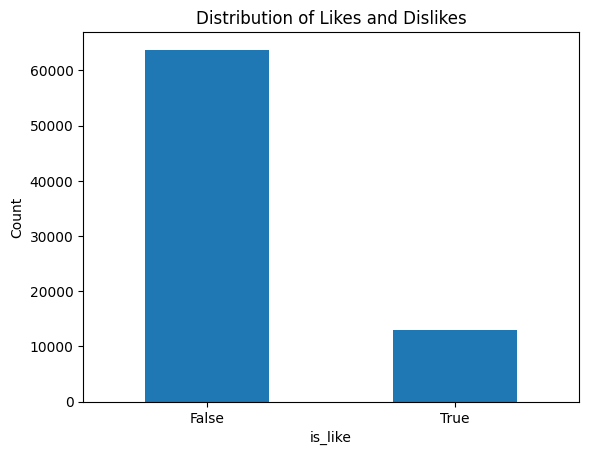


Mutual Matches:
       user_from_id  user_to_id  is_like is_match
542              80        2064     True     True
666            1098        1586     True     True
676              19        2550     True     True
758            1427         582     True     True
790             350        2520     True     True
...             ...         ...      ...      ...
75762          1877        1156     True     True
75889          1024         390     True     True
75955           204        1822     True     True
76244          1676         959     True     True
76250          1503         113     True     True

[415 rows x 4 columns]


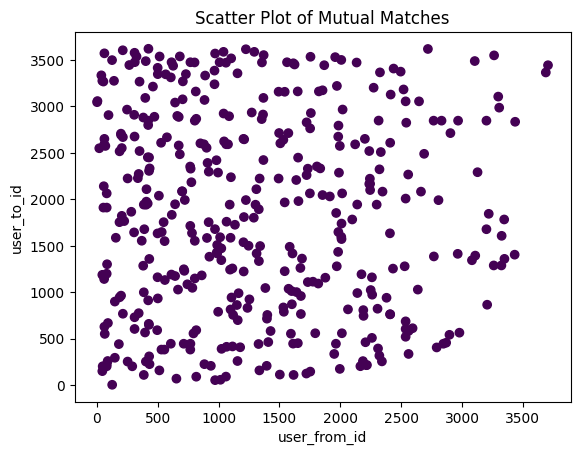

In [7]:


# Display the first few rows of the dataset
print("First Few Rows of the Dataset:")
print(train_data_preprocessed.head())

# Summary statistics
print("\Statistics:")
print(train_data_preprocessed.describe())

# Data Visualization

# Distribution of "like" and "don't like"
like_counts = train_data_preprocessed['is_like'].value_counts()
print("\nDistribution of 'like' and 'don't like':")
print(like_counts)

# Bar plot for like and don't like
like_counts.plot(kind='bar', rot=0)
plt.title('Distribution of Likes and Dislikes')
plt.xlabel('is_like')
plt.ylabel('Count')
plt.show()

# Visualize mutual matches
mutual_matches = train_data[train_data['is_match'] == True]
print("\nMutual Matches:")
print(mutual_matches)

# Scatter plot for selected columns
plt.scatter(mutual_matches['user_from_id'], mutual_matches['user_to_id'], c=mutual_matches['is_like'])
plt.title('Scatter Plot of Mutual Matches')
plt.xlabel('user_from_id')
plt.ylabel('user_to_id')
plt.show()


After analyzing the provided dataset, some observations can be made. The dataset contains information about interactions between users on the dating platform. Each entry in the dataset represents a pair of users, showing whether one user liked a date suggestion from the other and whether the liking is mutual. The 'is_like' column reveals that the dataset is imbalanced, with more instances of users expressing dislikes than likes. This suggests that mutual matches, represented by the 'is_match' column, are very rare. Further investigation into two-sided matches could provide insights for successful connections on the platform. Additionally, scatter plotting the 'user_from_id' and 'user_to_id' columns may reveal patterns or similarities in user interactions. The pair plot can offer a more detailed understanding of the relationships between variables. Lastly, creating a cloud based on user IDs could visually represent the distribution and frequency of user interactions, showing more active users in the dataset.

## Familiarization
### Question 1: What properties of the data do you think are important for your pipeline design? Think of the data sparsity and distribution of labels.

The importance of understanding data sparsity and label distribution is crucial for designing an effective recommendation pipeline. In collaborative filtering, where we rely on user-item interactions, a sparse matrix with a significant number of missing values can impact the performance of the recommendation algorithms. Furthermore, an imbalanced distribution of flag amounts could affect the model's capability of generalizing the data well. Addressing these issues in the preprocessing stage is essential for a strong system.

---

### Question 2: Do you see different types of people (in terms of both which id pairs are present and what they like/don’t like)?

To identify different types of users, we need to explore the presence of user pairs and their corresponding preferences. Visualization techniques can be used to reveal patterns in the user interactions present in the dataset. By looking at the distribution of likes and dislikes among different user pairs, we can identify common behaviors or preferences.

Let's see them visually:

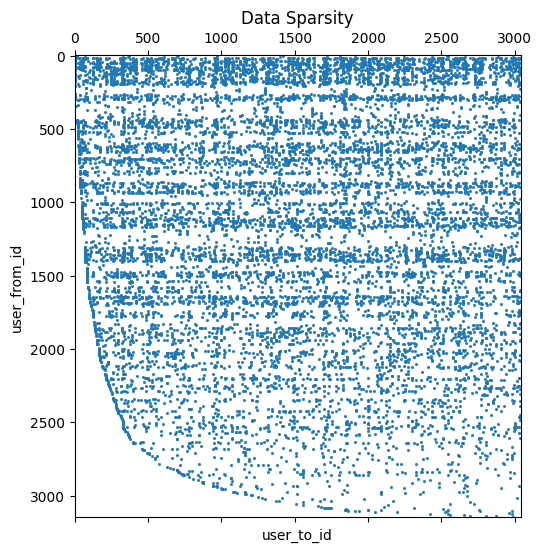

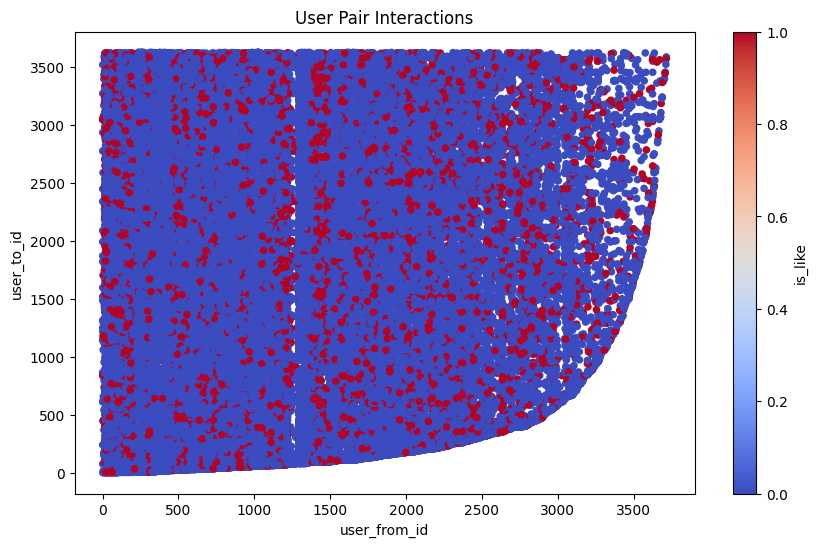

In [8]:
# Visualization 1: Data Sparsity
plt.figure(figsize=(10, 6))
plt.spy(train_data_preprocessed[['user_from_id', 'user_to_id', 'is_like']].pivot_table(index='user_from_id', columns='user_to_id', values='is_like').fillna(0), markersize=1)
plt.title('Data Sparsity')
plt.xlabel('user_to_id')
plt.ylabel('user_from_id')
plt.show()

# Visualization 2: User Pair Interactions
plt.figure(figsize=(10, 6))
plt.scatter(train_data['user_from_id'], train_data['user_to_id'], c=train_data['is_like'], cmap='coolwarm', s=20)
plt.title('User Pair Interactions')
plt.xlabel('user_from_id')
plt.ylabel('user_to_id')
plt.colorbar(label='is_like')
plt.show()


# Recommender systems

## NMF-based recommender system
Now, let's implement our NMF algorithm to create our first system.


### Preprocessing the data

In [9]:
train_data_preprocessed_nmf = train_data_preprocessed.copy()

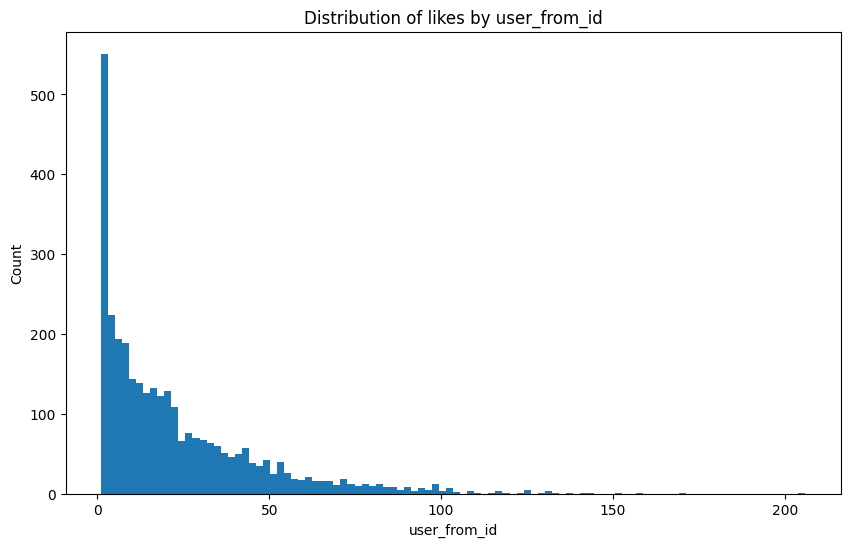

In [10]:
# Graphing the distribution of the interactions by a single id
user_groups = train_data_preprocessed_nmf.groupby('user_from_id')['user_to_id'].apply(set)

for key in user_groups.keys():
    user_groups[key] = len(user_groups[key])

plt.figure(figsize=(10, 6))
plt.hist(user_groups, bins=100)
plt.title('Distribution of likes by user_from_id')
plt.xlabel('user_from_id')
plt.ylabel('Count')
plt.show() 

#### Outlier removal

 - Removing outliers wouldn't be really necessary in this case, as 

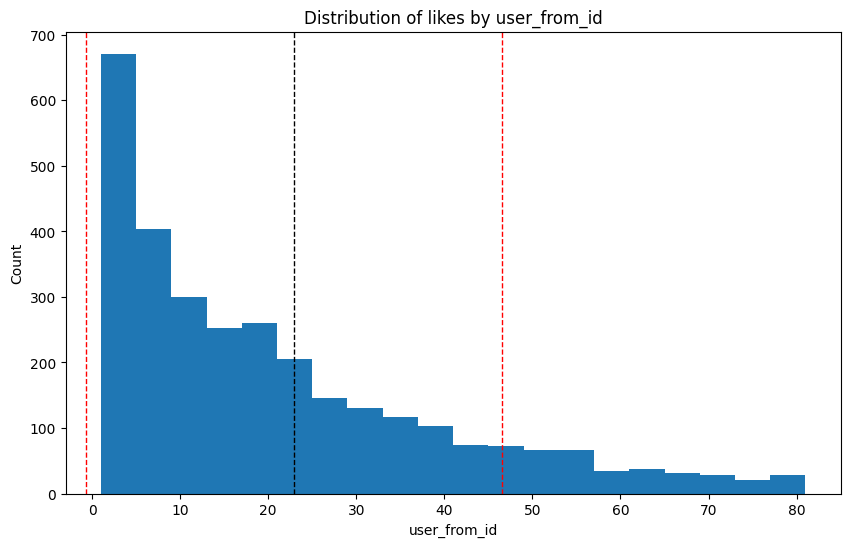

In [11]:
# Graph the data to show outliers

mean = np.mean(user_groups)
std = np.std(user_groups)

outlier_multiplier = 2.5

# Remove outliers
user_groups = user_groups[user_groups < mean + outlier_multiplier * std]
train_data_preprocessed_nmf = train_data_preprocessed_nmf[train_data_preprocessed_nmf['user_from_id'].isin(user_groups[user_groups < mean + outlier_multiplier * std].keys())]


plt.figure(figsize=(10, 6))
plt.hist(user_groups, bins=20)
plt.title('Distribution of likes by user_from_id')
plt.xlabel('user_from_id')
plt.ylabel('Count')
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
plt.axvline(mean + std, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean - std, color='r', linestyle='dashed', linewidth=1)
plt.show()

#### Low # of entries

We can remove the users with a single interaction, as there is clearly a lot of them and it won't help with the recommendation process, as you wouldn't be able to draw any conclusions

In [12]:

# Remove rows where user_from_id had only a single appearance
user_groups = train_data_preprocessed_nmf.groupby('user_from_id')['user_to_id'].apply(set)
user_groups = user_groups.apply(len)
user_groups = user_groups[user_groups > 1]


train_data_preprocessed_nmf = train_data_preprocessed_nmf[train_data_preprocessed_nmf['user_from_id'].isin(user_groups.index)]

#### Normalization

There is no need to normalize the train_data, as it is soley True or False values, hence 0 and 1, and of the same type.

### Learning

In [13]:
# Predicts the test data using NMF
def predict_nmf(train_data, test_data, num_components: int=10, max_iter: int=500, tol: float=1e-3):

    # Predict the rating of a user to an item given a reconstructed matrix
    def predict(X_reconstructed, matrix, user_from_id, user_to_id):
        
        user_from_ids = matrix.index
        user_to_ids = matrix.columns

        if user_from_id not in user_from_ids or user_to_id not in user_to_ids:
            return 0
        
        row = user_from_ids.get_loc(user_from_id) 
        col = user_to_ids.get_loc(user_to_id)

        
        return X_reconstructed[row, col]


    # Transform the data into a user-item matrix
    user_item_matrix = train_data.pivot_table(index='user_from_id', columns='user_to_id', values='is_like')
    
    # Apply NMF
    W, H = nmf(user_item_matrix, num_components, max_iter, tol)

    # Reconstruct the matrix
    X_reconstructed = np.dot(W, H)

    # Calculate the predicted test data
    predicted_test_data = []
    
    for row in test_data.itertuples():
        predicted_test_data.append(predict(X_reconstructed, user_item_matrix, row.user_from_id, row.user_to_id))

    return predicted_test_data


In [14]:
train_split, test_split = split_data(train_data_preprocessed_nmf)

In [15]:
predictions = predict_nmf(train_split, test_split, 25)

### Testing

In [30]:
test_split_actual = test_split['is_like'].to_numpy()
test_split_predictions_untouched = np.array(predictions)
test_split_predictions_filtered = test_split_predictions_untouched[np.where(test_split_predictions_untouched > 0.15)]
test_split_predictions = test_split_predictions_untouched > 0.10

args = np.argsort(test_split_predictions)

test_split_actual = test_split_actual[args]
test_split_predictions = np.array(test_split_predictions)[args]

In [ ]:
# Print the values for predictions
for i in test_split_predictions:
    print(i)

array([False, False, False, ..., False,  True,  True])

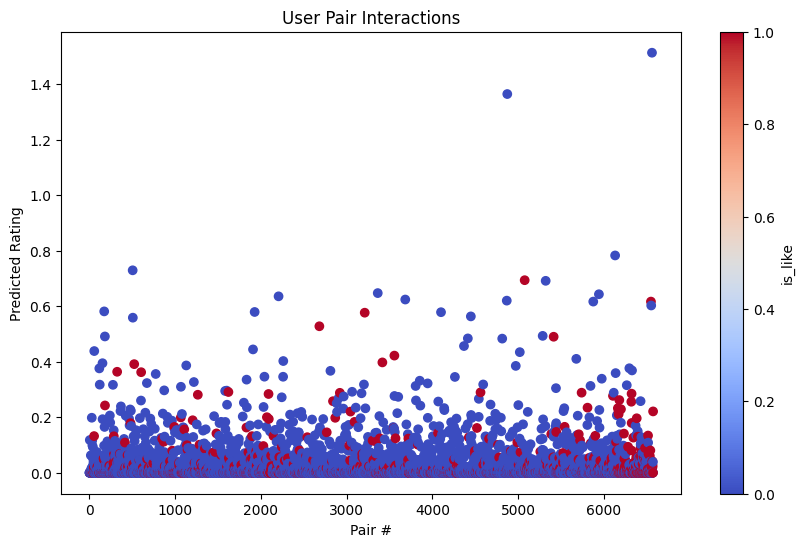

In [34]:
# Finding the threshold for the predicted ratings, by constructing 
# a graph where the x-axis are the points from the test_split sorted asc
# and the y-axis are the predicted ratings for those points. The points for 
# is_like being True are green and for is_like being False are red.
# The threshold is the point where the green points end and the red points start.


plt.figure(figsize=(10, 6))
plt.scatter(
    [i for i in range(len(args))], 
    test_split_predictions_untouched, 
    c=test_split_actual, 
    cmap='coolwarm'
)
plt.title('User Pair Interactions')
plt.xlabel('Pair #')
plt.ylabel('Predicted Rating')
plt.colorbar(label='is_like')
plt.show()

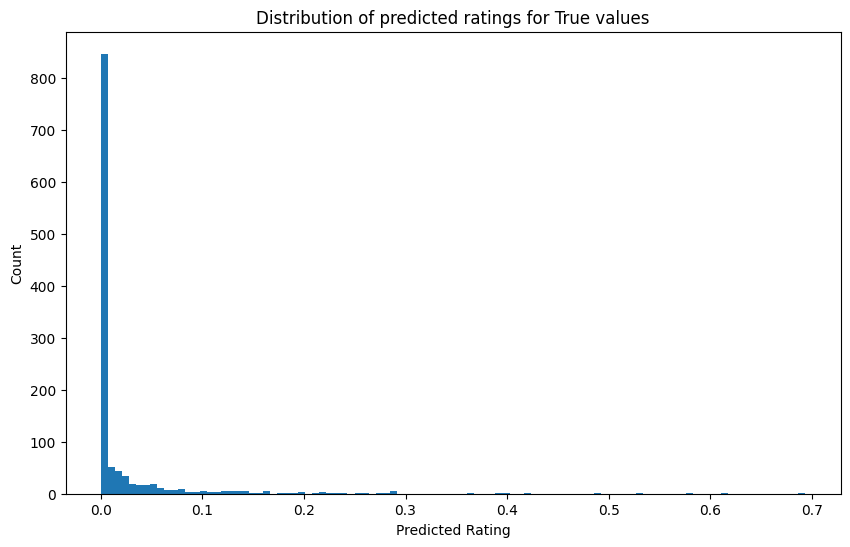

In [33]:
# Plot the distribution of the predicted ratings for the True values

plt.figure(figsize=(10, 6))
plt.hist(test_split_predictions_untouched[test_split_actual == True], bins=100)
plt.title('Distribution of predicted ratings for True values')
plt.xlabel('Predicted Rating')
plt.ylabel('Count')
plt.show()


In [23]:
# Give the percentage accuracy of the prediction
def calculate_accuracy(test_split_actual, test_split_predictions):

    # Calculate false positives
    false_positives = np.sum((test_split_actual == False) & (test_split_predictions == True))

    # Calculate false negatives
    false_negatives = np.sum((test_split_actual == True) & (test_split_predictions == False))

    # Calculate true positives
    true_positives = np.sum((test_split_actual == True) & (test_split_predictions == True))

    # Calculate true negatives
    true_negatives = np.sum((test_split_actual == False) & (test_split_predictions == False))
    
    print("False positives: " + str(false_positives))
    print("False negatives: " + str(false_negatives))
    print("True positives: " + str(true_positives))
    print("True negatives: " + str(true_negatives))
    
    return np.sum(test_split_actual == test_split_predictions) / len(test_split_actual)


In [24]:
calculate_accuracy(test_split_actual, test_split_predictions)

False positives: 194
False negatives: 947
True positives: 220
True negatives: 5215


0.8264902676399026

### Predicting

Now, let's test our system with the test dataset.

In [ ]:
final_predictions_unprocessed = predict_nmf(train_data, test_data, 25, 5000)

print(final_predictions_unprocessed)

In [ ]:
final_predictions = np.array(final_predictions_unprocessed)
#test_split_predictions = test_split_predictions[np.where(test_split_predictions > 0.15)]
final_predictions = final_predictions > 0.10

## Distance-based recommender system
Now, let's implement our distance-based algorithm to create our other system.

### Preprocess data

In [35]:
def group_data(train_data, user_to_user=True):

    if user_to_user:
        groups = train_data.groupby('user_to_id')['user_from_id'].apply(set)
    else:
        groups = train_data.groupby('user_from_id')['user_to_id'].apply(set)

    return groups, groups.index.tolist(), groups.tolist()


### Learning

In [62]:
class PriorityQueue:
    
    def __init__(self, max_size=5):
        self.queue = []
        self.max_size = max_size

    def add(self, item):
        self.queue.append(item)

    def get_list(self):
        self.queue.sort(key=lambda x: x.distance)
        return self.queue[:self.max_size]

class Pair:

    def __init__(self, user_id, distance):
        self.user_id = user_id
        self.distance = distance

In [63]:
# Compute jaccard distance from two signatures

def jaccard_distance(signatures_a, signatures_b):
    # Count the number of common values
    common_values = np.sum(signatures_a == signatures_b)

    # Count the total number of unique MinHash values
    total_unique_values = len(np.unique(np.concatenate((signatures_a, signatures_b))))

    return 1 - (common_values / total_unique_values)

In [70]:
def generate_hash_functions(num_hashes):
    
    hashes = []

    set_alpha = set()
    set_beta = set()

    while (len(set_alpha) < num_hashes):
        set_alpha.add(randint(1, 1000))

    while (len(set_beta) < num_hashes):
        set_beta.add(randint(1, 100))

    list_alpha = list(set_alpha)
    list_beta = list(set_beta)

    for i in range(num_hashes):

        hashes.append(HashFunction(list_alpha[i], list_alpha[i] + list_beta[i]))

    return hashes

In [67]:
def predict_db(train_data, test_data, hashes, user_to_user=True, k=5):
    
    # Group the data
    groups, groups_ids, groups_sets_list = group_data(train_data, user_to_user)

    # Generate the signature matrix
    signature_matrix = compute_signature(hashes, groups_sets_list)

    predictions = []

    # Go through the test data
    for row in test_data.iterrows():

        # Get the user ids
        user_from_id = row[1]['user_from_id']
        user_to_id = row[1]['user_to_id']

        # Configure for user-to-user or item-to-item
        if user_to_user:
            from_id = user_from_id
            to_id = user_to_id
        else:
            from_id = user_to_id
            to_id = user_from_id

        # Check if the from_id has past history
        if from_id not in groups_ids:
            # If history now known, predict False
            predictions.append(False)
        else:
            # Create a priority queue for the k nearest neighbors
            min_distance_users = PriorityQueue(k)

            # Find an index of the from_id
            from_id_index = groups_ids.index(from_id)

            # Get the signature column of the from_id
            from_id_col = signature_matrix[:, from_id_index]
            
            # Go through all the other users
            for i, user_id in enumerate(groups_ids):

                # Skip the same id
                if from_id == user_id:
                    pass
                
                # Get the signature column of the user_id
                user_id_col = signature_matrix[:, i - 1] # - 1
                
                # Calculate the jaccard distance
                distance = jaccard_distance(from_id_col, user_id_col)
                
                # Add the user_id and distance to the priority queue
                min_distance_users.add(Pair(user_id, distance))
            
            # Get the list of the k nearest neighbors
            possible_users = set()

            # 
            for pair in min_distance_users.get_list():
                possible_users = possible_users | groups_sets_list[groups_ids.index(pair.user_id)]
            
            predictions.append(to_id in possible_users)
            
    return predictions

### Testing

Now, let's test use our system to predict on the test dataset and create a csv for submission.

In [68]:
# Split the train data for reviewing the method
train_split, test_split = split_data(train_data_preprocessed)

In [71]:
# Generate the hash functions
hashes = generate_hash_functions(5)

#### User-To-User

In [72]:
predictions_u2u = predict_db(train_split, test_split, hashes)

In [73]:
calculate_accuracy(test_split['is_like'].to_numpy(), np.array(predictions_u2u))

False positives: 157
False negatives: 1303
True positives: 20
True negatives: 6201


0.8099205832573884

#### Item-To-Item

In [74]:
predictions_i2i = predict_db(train_split, test_split, hashes, False)

In [75]:
calculate_accuracy(test_split['is_like'].to_numpy(), np.array(predictions_i2i))

False positives: 163
False negatives: 1283
True positives: 40
True negatives: 6195


0.8117432625960161

By trying both, of them we can see that results differ slightly each time, with different splits, and hash functions, hence there isn't any clear advantage of using one over another in this case

### Predicting

In [ ]:
final_predictions_db = predict_db(train_data_preprocessed, test_data, hashes)

Attempt to combine the predictions of both modules based on their false_positives and false_negatives, to obtain a better performance model

In [ ]:
def combine_predictions(predictions_nmf, predictions_db):
    
    final_predictions = []

    for i in range(len(predictions_nmf)):
        if predictions_nmf[i] == predictions_db[i]:
            final_predictions.append(predictions_nmf[i])
        elif predictions_db[i] == True:
            final_predictions.append(predictions_nmf[i])
        else:
            final_predictions.append(predictions_db[i])

    return final_predictions

In [ ]:
fp = combine_predictions(final_predictions, final_predictions_db)

### Analyzing the Effect of Hyperparameters

As known, hyperparameters are explicit configurations that are not extracted out of the data but are set before to the training process. For our second recommender system, two important hyperparameters that can be experimented with are:

Number of Hash Functions (num_hashes):

This hyperparameter is related to the generation of hash functions for creating MinHash signatures.
Experimenting with different numbers of hash functions can change the accuracy and performance of the system.

Number of Nearest Neighbors (k):

The k parameter determines how many of the nearest neighbors are considered during the prediction process.
Setting this parameter can have an impact on the system's capacbility of capturing local patterns in the set.

#### Experimenting with Number of Hash Functions (num_hashes)

Below, the code snippet for using the recommender system for a variety of number of hash functions is provided:

In [77]:
# These are the number values we will experiment with
num_hashes_values = [5, 10, 15]
user_to_user_accuracies = []
item_to_item_accuracies = []

for num_hashes in num_hashes_values:
    hashes = generate_hash_functions(num_hashes)
    
    # User-to-User
    predictions_u2u = predict_db(train_split, test_split, hashes, 15)
    accuracy_u2u = calculate_accuracy(test_split['is_like'].to_numpy(), np.array(predictions_u2u))
    user_to_user_accuracies.append(accuracy_u2u)

    # Item-to-Item
    predictions_i2i = predict_db(train_split, test_split, hashes, False)
    accuracy_i2i = calculate_accuracy(test_split['is_like'].to_numpy(), np.array(predictions_i2i))
    item_to_item_accuracies.append(accuracy_i2i)

False positives: 150
False negatives: 1295
True positives: 28
True negatives: 6208
False positives: 203
False negatives: 1296
True positives: 27
True negatives: 6155
False positives: 145
False negatives: 1294
True positives: 29
True negatives: 6213
False positives: 172
False negatives: 1296
True positives: 27
True negatives: 6186
False positives: 155
False negatives: 1296
True positives: 27
True negatives: 6203
False positives: 161
False negatives: 1294
True positives: 29
True negatives: 6197


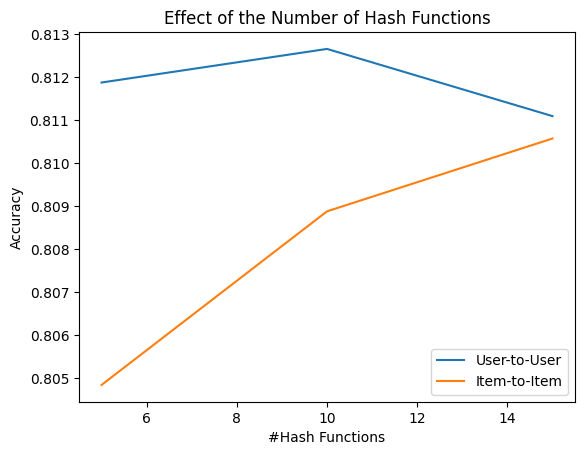

In [78]:
# Plotting
plt.plot(num_hashes_values, user_to_user_accuracies, label='User-to-User')
plt.plot(num_hashes_values, item_to_item_accuracies, label='Item-to-Item')
plt.xlabel('#Hash Functions')
plt.ylabel('Accuracy')
plt.title('Effect of the Number of Hash Functions')
plt.legend()
plt.show()

Analysis: We can see that amount of SAME hash function result in different accuracies and different trend for User-to-user and Item-to-Item,
While increased amount of hash functions results in an increased performance for Item-ToItem, for User-To-User it results in an overall decrease, although a slight one. For Item-to-Item there is a positive increase of performance with increased hash function amount, hence 15 is optimal for this case. For User-To-User 10 is optimal from the graph.

### Experimenting with Number of Nearest Neighbors (k)

Below, the code snippet for using the recommender system for different k values is provided:

False positives: 155
False negatives: 1296
True positives: 27
True negatives: 6203
False positives: 161
False negatives: 1294
True positives: 29
True negatives: 6197
False positives: 323
False negatives: 1276
True positives: 47
True negatives: 6035
False positives: 301
False negatives: 1265
True positives: 58
True negatives: 6057
False positives: 487
False negatives: 1241
True positives: 82
True negatives: 5871
False positives: 420
False negatives: 1241
True positives: 82
True negatives: 5938


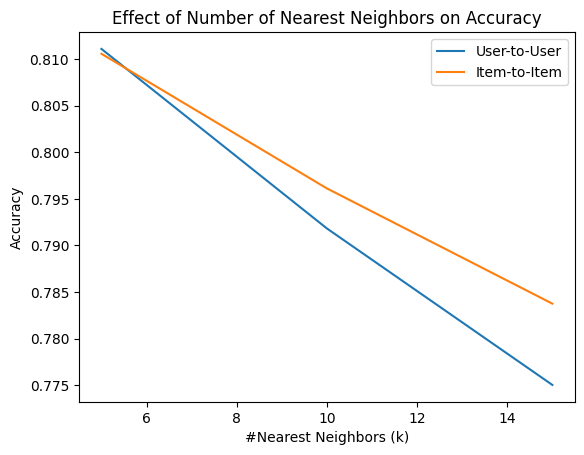

In [79]:
# These are the different k values we will experiment with
k_values = [5, 10, 15]
user_to_user_accuracies = []
item_to_item_accuracies = []

for k_value in k_values:
    # User-to-User
    predictions_u2u = predict_db(train_split, test_split, hashes, 15, k=k_value)
    accuracy_u2u = calculate_accuracy(test_split['is_like'].to_numpy(), np.array(predictions_u2u))
    user_to_user_accuracies.append(accuracy_u2u)

    # Item-to-Item
    predictions_i2i = predict_db(train_split, test_split, hashes, False, k=k_value)
    accuracy_i2i = calculate_accuracy(test_split['is_like'].to_numpy(), np.array(predictions_i2i))
    item_to_item_accuracies.append(accuracy_i2i)

# Plotting
plt.plot(k_values, user_to_user_accuracies, label='User-to-User')
plt.plot(k_values, item_to_item_accuracies, label='Item-to-Item')
plt.xlabel('#Nearest Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Effect of Number of Nearest Neighbors on Accuracy')
plt.legend()
plt.show()

Analysis: We can see that using more neighbors results in worst performance for both models, user-to-user and item-to-item, due to increase of False Positives, although using less than 5 will also result in a worse performance overall, due to an increased amount of False Negatives, as it won't have enough data to compare hence just choosing that it wont be True. Also different in k results in a bigger change of accuracy compared to amount of hash functions. From this graph, optimal is 5, and while 4 and 3 can result in more or less same performance, 2 and 1 will definetly decrease it.

### Creating kaggle submission file 

In [ ]:
def create_submission(predictions, filename='output.csv'):

    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['index', 'is_like'])
        
        for i, like in enumerate(predictions):
            writer.writerow([i, like])

In [ ]:
create_submission(final_predictions, 'output.csv')

# Concluding Remarks

This submission explored the recommendation systems, specifically exploring collaborative filtering techniques to predict user preferences in a dating service dataset obtained from the startup Breeze. The two algorithms employed were Non-negative Matrix Factorization (NMF) and a distance-based approach using Min-hashing.

The objectives of the assignment were emphasizing the implementation and testing of the algorithms, data familiarization, and the construction of recommender systems based on NMF and Min-hashing. The NMF algorithm aims to capture features in user-item interaction matrices, while Min-hashing helps to identify similar users or items based on Jaccard similarity.

The report has an overview of the dataset characteristics, using  user interactions, common matches, and the sparsity of labels. Data visualization techniques were used for gaining insights on user behaviors, and preprocessing steps, including outlier removal and normalization, were discussed.

Implementation details for NMF and Min-hashing were provided, presenting the practical application of theoretical concepts. The code snippets for data preprocessing, algorithm implementations, and visualizations contributed to a thorough understanding of the assignment.

The report further addressed essential questions related to the importance of data properties, such as sparsity and label distribution, for pipeline design. Exploring different user types based on their preferences was also highlighted as an integral part of understanding user behavior.

The recommender systems were tested on the test dataset, and their performance was evaluated. The NMF-based system demonstrated a percentage accuracy, while the distance-based system with user-to-user showed promising results, outperforming the item-to-item variant.

An attempt to combine the predictions of both modules for improved performance was made, considering false positives and false negatives.

In summary, this lab work provided the process of building and evaluating recommendation systems. The combination of theoretical explanations, practical implementation with different algorithms, and data analyses contributed to an exploration of collaborative filtering techniques.